# Object Detection using a subset of Pascal VOC dataset
M1 - DSAI
University Côte d'Azur

Diane Lingrand Diane.Lingrand@univ-cotedazur.fr

2024-2025


In [1]:
import numpy as np
import torch
import random
import tensorflow as tf

In [2]:
import xml.etree.ElementTree as ET
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

In [3]:
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Reshape
from keras.layers import RandomContrast, RandomBrightness
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Dataset

The images are similar to the images processed in previous labs (CNN, XAI). However, we also need the box coordinates. These informations are stored in the xml you already have downloaded but we need to read these informations for this lab.

The computations will be heavier than previously. If you do not own a GPU on your labtop, we strongly encourage you to work on google colab. If you have not already downloaded the CatDogBird dataset on your google drive, you can use my share directory (just create a shortcut to it): 

https://drive.google.com/drive/folders/1mvjR8HqD__VyVINltCzzqyPj3pu3RAv-?usp=sharing

In [5]:
# set your path here
homedir = 'C:\\Users\\Admin\\Master Program\\Introduction to Deep Learning\\Labs\\CatDogBird\\'
#homedir='/content/drive/My Drive/CatDogBird/' #or the name of your shortcut

### Read the xml files for classes and box coordinates

In [6]:
classesNames=['cat','dog','bird']
nbClasses = len(classesNames)

listXml = glob.glob(homedir+'*.xml')
listImgFiles=[]
listLabels=[]
listBoxes=[]

for xml in listXml:
    bb = []
    tree = ET.parse(xml)
    doc = tree.getroot()
    nbObj = 0
    for d in doc.findall('.//object/name'):
        if d.text=='cat':
            listLabels.append(0)
            listImgFiles.append(xml[:-4]+'.jpg')
        elif d.text=='dog':
            listLabels.append(1)
            listImgFiles.append(xml[:-4]+'.jpg')
        elif d.text=='bird':
            listLabels.append(2)
            listImgFiles.append(xml[:-4]+'.jpg')
    # for this lab, we also need to load the box coordinates
    for d in doc.findall('.//object/bndbox/xmin'):
        bb.append(int(d.text))
    for d in doc.findall('.//object/bndbox/ymin'):
        bb.append(int(d.text))
    for d in doc.findall('.//object/bndbox/xmax'):
        bb.append(int(d.text))
    for d in doc.findall('.//object/bndbox/ymax'):
        bb.append(int(d.text))
        
    listBoxes.append(bb)


In [7]:
from collections import Counter
Counter(listLabels)

Counter({0: 745, 1: 694, 2: 568})

### Let's plot some images with the true box

Filename:  C:\Users\Admin\Master Program\Introduction to Deep Learning\Labs\CatDogBird\2007_002400.jpg
Coordinates:  [2, 27, 305, 499]
Image shape:  (500, 350, 3)


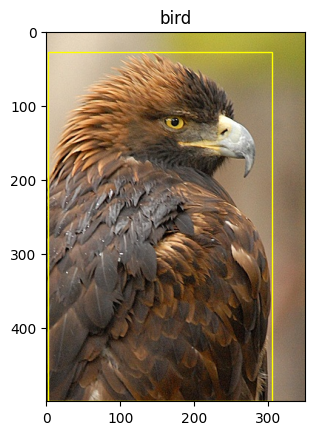

In [8]:
i = 10 # change this index to see other images with their boxes
filename = listImgFiles[i]
print('Filename: ',filename)
bb = listBoxes[i]
print('Coordinates: ',bb)
img = plt.imread(filename)
print('Image shape: ',img.shape)
plt.imshow(img)
plt.title(classesNames[listLabels[i]])
rect = patches.Rectangle((bb[0],bb[1]),bb[2]-bb[0],bb[3]-bb[1], linewidth=1, edgecolor='yellow', facecolor='none')
plt.gca().add_patch(rect)

### Normalisation of boxes coordinates

In [9]:
nbData = len(listImgFiles)

X = np.empty(shape=(nbData,224,224,3))
yBoxes = np.empty(shape=(nbData,4),dtype=np.float32)
i = 0
for imageFilename in tqdm(listImgFiles): 
    theimage = plt.imread(imageFilename)
    h = theimage.shape[0]
    w = theimage.shape[1]
    img = resize(theimage,(224,224,3))
    im = image.img_to_array(img)
    # im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    X[i,:,:,:] = im
   
    yBoxes[i][0] = listBoxes[i][0]/w
    yBoxes[i][1] = listBoxes[i][1]/h
    yBoxes[i][2] = listBoxes[i][2]/w
    yBoxes[i][3] = listBoxes[i][3]/h
    
    i += 1


100%|██████████| 2007/2007 [00:43<00:00, 46.20it/s]


In [10]:
# listBoxes is no more necessary
del listBoxes

In [11]:
#train/test split
X_train, X_test, y_boxes_train, y_boxes_test, y_labels_train, y_labels_test, listImgFilesTrain, listImgFilesTest = train_test_split(X, yBoxes, listLabels, listImgFiles, test_size=0.2, random_state=42)

In [12]:
# these variables are no more necessary
del X, yBoxes, listLabels, listImgFiles

In [13]:
# convert to numpy arrays
y_labels_train = np.array(y_labels_train)
y_labels_test = np.array(y_labels_test)

In [14]:
y_labels_train.shape

(1605,)

In [15]:
print(np.unique(y_labels_train, return_counts=True))
print(np.unique(y_labels_test, return_counts=True))

(array([0, 1, 2]), array([605, 549, 451], dtype=int64))
(array([0, 1, 2]), array([140, 145, 117], dtype=int64))


In [16]:
yLabelsCategoricalTrain = keras.utils.to_categorical(y_labels_train, nbClasses)
yLabelsCategoricalTest = keras.utils.to_categorical(y_labels_test, nbClasses)

## Neural network model

<font color="green"><b>Question:</b></font> Here is a draft of a model. Add or modify layers.

Execute SVM part

In [17]:
from sklearn import svm

In [18]:
VGGmodel = VGG16(weights='imagenet', input_shape=(224,224,3),include_top=False)
m = VGGmodel.output  # or VGGmodel.output
# m = MaxPooling2D(pool_size = (3,3), strides=2, padding='same')(m)
m = GlobalAveragePooling2D()(m)

m = Flatten()(m)
# m = Dropout(0.2)(m)
# m = Dense(1024, activation='relu')(m)

# localisations = Dense(4, activation='sigmoid', name='boxLayer')(m)
# predictions = Dense(nbClasses, activation='softmax', name='clLayer')(m)


model = Model(inputs = VGGmodel.input,outputs = m)


In [19]:
for layer in model.layers[:18]:
   layer.trainable = False
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
# your work here

# model.summary()
# loss function is composed of 2 terms: one for the localisations and one for the predictions
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
# ourCallback = keras.callbacks.EarlyStopping(monitor='val_clLayer_accuracy', min_delta=0.0001, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)


Extract features

In [21]:
X_train_feature = model.predict(X_train)

51/51 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step


In [22]:
X_test_feature = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step


In [23]:
X_train_feature.shape

(1605, 512)

Create and train SVM

In [3]:
import sklearn
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error

Linear part

In [4]:
svm_pipeline_regression = make_pipeline(svm.SVR(kernel='linear'))
estimators = [sklearn.base.clone(svm_pipeline_regression).fit(X_train_feature, y_boxes_train[:, i]) for i in range(4)]


NameError: name 'svm' is not defined

In [26]:
y_boxes_preds = []
for i, est in enumerate(estimators):
    y_boxes_pred = est.predict(X_test_feature)
    # print("pred: ", y_boxes_pred)
    y_boxes_test_i = y_boxes_test[:,i]
    # print("test", y_boxes_test_i)
    # break
    print(f"feature {i}: ", mean_squared_error(y_boxes_test_i, y_boxes_pred))
    y_boxes_preds.append(y_boxes_pred)

feature 0:  0.027807680982867556
feature 1:  0.02305894169913088
feature 2:  0.025500964173294866
feature 3:  0.022776062042189286


In [27]:
y_boxes_preds = np.array(y_boxes_preds).T

In [28]:
y_boxes_preds.shape

(402, 4)

In [29]:
listBoxes_new = np.zeros(shape=y_boxes_preds.shape)

Plot it


In [30]:
i = 10 # change this index to see other images with their boxes
filename = listImgFiles[i]
print('Filename: ',filename)
img = plt.imread(filename)
h = img.shape[0]
w = img.shape[1]
# Return the normal coordinate
listBoxes_new[:, 0] = y_boxes_preds[:,0]*w
listBoxes_new[:, 2] = y_boxes_preds[:,2]*w
listBoxes_new[:, 1] = y_boxes_preds[:,1]*h
listBoxes_new[:, 3] = y_boxes_preds[:,3]*h
bb = listBoxes_new[i]

print('Coordinates: ',bb)

print('Image shape: ',img.shape)
plt.imshow(img)
plt.title(classesNames[listLabels[i]])
rect = patches.Rectangle((bb[0],bb[1]),bb[2]-bb[0],bb[3]-bb[1], linewidth=1, edgecolor='yellow', facecolor='none')
plt.gca().add_patch(rect)

NameError: name 'listImgFiles' is not defined

Classification part

In [1]:
svm_pipeline_classification = make_pipeline(StandardScaler(), svm.SVC(kernel='poly',gamma='scale',C=1e6, coef0=-1,degree=6, decision_function_shape='ovr', tol=1e-6))
svm_pipeline_classification.fit(X_train_feature, y_labels_train)

NameError: name 'make_pipeline' is not defined

In [ ]:
y_pred_classification = svm_pipeline_classification.predict(X_test_feature)

In [ ]:
print("acc: ", accuracy_score(y_pred_classification, y_labels_test))

acc:  0.3706467661691542


<font color="green"><b>Question:</b></font> Count the number of parameters to be learned (freeze the VGG weights). Learn the added layers, measure the CO2 consumption, evaluate performance metrics and plot history.

<font color="green"><b>Question:</b></font> Are you satisfied with the results? Try to improve the network. You can make use of the learning techniques we have seen: dropout, batch normalisation, data augmentation (be careful with the impact of geometrical augmentation for the boxes coordinates).

In [ ]:
# your work here

### Display the result on test images with true box, predicted box, true class and predicted class

<font color="green"><b>Question:</b></font> Previously, a cell was responsible of displaying an image with the true box. Add the predicted box. Add a title with true and predicted classes. Hint: don't forget to multiply coordinates of boxes by true image dimension of the image.

In [ ]:
# your work

## Waiting for the network to converge
When your computer is working for you, you have time to answer the following questions.

### lower bound for accuracy

<font color="green"><b>Question:</b></font> Do you remember the value of accuracy if prediction is random or if the prediction is always the majority class?

In [ ]:
# your work here

### error of one pixel for bounding box

<font color="green"><b>Question:</b></font> We consider the output features of layer 'block5_conv3'. Imagine that the prediction has an error of 1 pixel in the 14*14 feature maps. What is the mse value in this case?

In [ ]:
# your work here

<font color="green"><b>Question:</b></font> Same question if we used the 7x7x512 output features of VGG16

In [ ]:
# your work here

<font color="green"><b>Question:</b></font> Same question for the IoU metric.

In [ ]:
# your work here

## Using an IoU loss

### first, let's compute iuo for simple boxes

Here is some code. Do you think it computes the IoU correctly?

In [ ]:
a = np.array([1,1,3,3])
b = np.array([2,2,4,4])
c = np.array([5,5,7,7])
d = np.array([6,6,8,8])
e = np.array([3,3,1,1])
f = np.array([4,4,2,2])

yt = np.array([a,c,e])
yp = np.array([b,d,f])
yt.shape

In [ ]:
def iou(y_true,y_pred):
    # order the coordinates if needed
    xt0 = np.min(y_true[:,[0,2]],axis=1)
    xt1 = np.max(y_true[:,[0,2]],axis=1)
    yt0 = np.min(y_true[:,[1,3]],axis=1)
    yt1 = np.max(y_true[:,[1,3]],axis=1)

    xp0 = np.min(y_pred[:,[0,2]],axis=1)
    xp1 = np.max(y_pred[:,[0,2]],axis=1)
    yp0 = np.min(y_pred[:,[1,3]],axis=1)
    yp1 = np.max(y_pred[:,[1,3]],axis=1)

    # area of each box
    true_area =(xt1-xt0)*(yt1-yt0)
    pred_area = (xp1-xp0)*(yp1-yp0)

    #coordinates of the intersection area
    ixmax = np.minimum(xt1,xp1)
    iymax = np.minimum(yt1,yp1)
    ixmin = np.maximum(xt0,xp0)
    iymin = np.maximum(yt0,yp0)
  
    # test if there is an intersection (otherwise intersection = 0)
    iw = np.clip(ixmax - ixmin, a_min=0, a_max=None)
    ih = np.clip(iymax - iymin, a_min=0, a_max=None)

    # intersection area
    inter_area = iw*ih
    union_area = true_area + pred_area - inter_area

    # nan or inf could be returned here
    return np.mean(inter_area/union_area)

In [ ]:
iou(yt,yp)

### then define a IoU loss by inheritence of Loss class

If the code is correct, this is the way to transform it to a loss function.

In [ ]:
from keras.losses import Loss

class InterOverUnion(Loss):
    def call(self, y_true, y_pred):
        # order the coordinates if needed
        xt0 = torch.min(y_true[:,[0,2]],axis=1).values
        xt1 = torch.max(y_true[:,[0,2]],axis=1).values
        yt0 = torch.min(y_true[:,[1,3]],axis=1).values
        yt1 = torch.max(y_true[:,[1,3]],axis=1).values

        xp0 = torch.min(y_pred[:,[0,2]],axis=1).values
        xp1 = torch.max(y_pred[:,[0,2]],axis=1).values
        yp0 = torch.min(y_pred[:,[1,3]],axis=1).values
        yp1 = torch.max(y_pred[:,[1,3]],axis=1).values

        # area of each box
        true_area = (xt1-xt0)*(yt1-yt0)
        pred_area = (xp1-xp0)*(yp1-yp0)

        #coordinates of the intersection area
        ixmax = torch.minimum(xt1,xp1)
        iymax = torch.minimum(yt1,yp1)
        ixmin = torch.maximum(xt0,xp0)
        iymin = torch.maximum(yt0,yp0)

        # test if there is an intersection (otherwise intersection = 0)
        iw = torch.clamp(ixmax - ixmin, min=0, max=None)
        ih = torch.clamp(iymax - iymin, min=0, max=None)

        # intersection area
        inter_area = iw*ih

        # union area as some of areas of boxes - intersection (otherwise counted twice)
        union_area = true_area + pred_area - inter_area
        # be careful of division by 0
        iou = inter_area / (union_area+keras.backend.epsilon())
 
        # different options: -log(iou), 1-iou ....
        return torch.mean(-torch.log(iou))

<font color="green"><b>Question:</b></font> Let's play with this new loss! Learn the neural network by modifying the 'mse' loss to this new IoU loss. As usual, compute metrics.

In [ ]:
# your work here

<font color="green"><b>Question:</b></font> What is the IoU value if the boxes do not have any intersection. In this case, how can the loss function help to modify the boxes coordinates?

In [ ]:
# your work here